In [18]:
import pandas as pd

In [60]:
df_train = pd.read_csv("./train_cleaned.csv")
df_val = pd.read_csv("./valid_cleaned.csv")
df_test = pd.read_csv("./test_cleaned.csv")

In [31]:
df_train[['Listing.Price.ClosePrice', 'Location.GIS.Latitude','Location.GIS.Longitude',]]

,Listing.Price.ClosePrice,Location.GIS.Latitude,Location.GIS.Longitude
0,520000.0,41.869956,-87.799225
1,390000.0,42.166776,-88.393876
2,305000.0,41.712421,-88.256825
3,200555.0,42.247830,-88.602640
4,775000.0,42.225507,-88.373335
...,...,...,...
85944,103900.0,41.799990,-89.678228
85945,45000.0,41.614549,-87.652772
85946,270000.0,42.263918,-88.006964
85947,240000.0,41.167427,-87.544012


In [32]:
import missingno as mssno

sum(df_train.isna().sum())

98

In [33]:
df_train = df_train.dropna()
df_train = df_train.sample(10000)

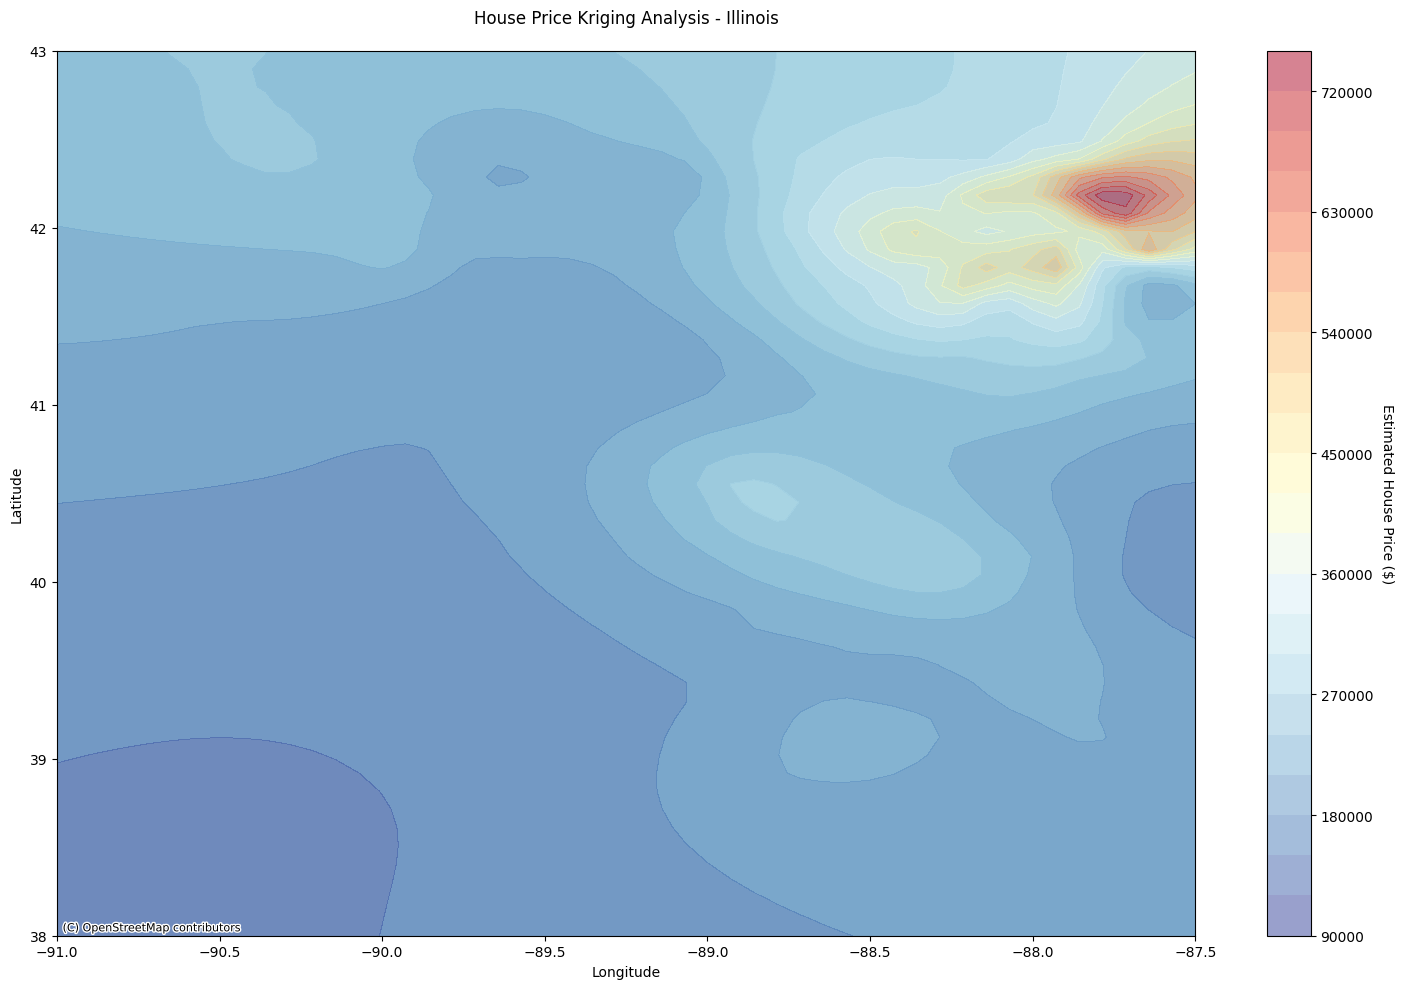


Kriging Analysis Statistics:
Mean predicted price: $198,225.86
Min predicted price: $114,353.20
Max predicted price: $741,446.79


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from pykrige.ok import OrdinaryKriging
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings('ignore')

# Create a grid of points covering Illinois
il_bounds = {
    'lat_min': 37,
    'lat_max': 43,
    'lon_min': -91.5,
    'lon_max': -87
}

grid_points = 50
lat = np.linspace(il_bounds['lat_min'], il_bounds['lat_max'], grid_points)
lon = np.linspace(il_bounds['lon_min'], il_bounds['lon_max'], grid_points)
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Prepare the data
X = df_train[['Location.GIS.Latitude', 'Location.GIS.Longitude']].values
y = df_train['Listing.Price.ClosePrice'].values

# Scale the prices for better kriging results
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Perform ordinary kriging
ok = OrdinaryKriging(
    X[:, 1],  # longitude
    X[:, 0],  # latitude
    y_scaled,
    variogram_model='linear',
    verbose=False
)

z, ss = ok.execute('grid', lon, lat)

# Transform predictions back to original scale
z_price = scaler.inverse_transform(z.reshape(-1, 1)).reshape(grid_points, grid_points)

# Create a figure with larger size
fig, ax = plt.subplots(figsize=(15, 10))

# Create contour plot
contour = ax.contourf(
    lon_grid, 
    lat_grid, 
    z_price,
    levels=20,
    cmap='RdYlBu_r',
    alpha=0.5
)

# Plot the sample points
scatter = ax.scatter(
    X[:, 0],
    X[:, 1],
    c=y,
    cmap='RdYlBu_r',
    s=20,
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

# Add colorbar
cbar = plt.colorbar(contour)
cbar.set_label('Estimated House Price ($)', rotation=270, labelpad=15)

# Add basemap
ax.set_xlim(il_bounds['lon_min'], il_bounds['lon_max'])
ax.set_ylim(il_bounds['lat_min'], il_bounds['lat_max'])
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Set title and labels
plt.title('House Price Kriging Analysis - Illinois', pad=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Print some statistics about the kriging results
print("\nKriging Analysis Statistics:")
print(f"Mean predicted price: ${z_price.mean():,.2f}")
print(f"Min predicted price: ${z_price.min():,.2f}")
print(f"Max predicted price: ${z_price.max():,.2f}")

In [54]:
from scipy.interpolate import griddata

# Load the cleaned data
train_df = pd.read_csv("train_cleaned.csv")
val_df = pd.read_csv("valid_cleaned.csv")
test_df = pd.read_csv("test_cleaned.csv")

# Prepare the grid for interpolation
grid_points = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))
z_price_flat = z_price.ravel()

# Interpolate kriging results for train data
train_coords = train_df[['Location.GIS.Longitude', 'Location.GIS.Latitude']].values
train_kriging_prices = griddata(
    points=grid_points, 
    values=z_price_flat, 
    xi=train_coords, 
    method='linear'
)
train_df['Kriging_Predicted_Price'] = train_kriging_prices

# Interpolate kriging results for validation data
val_coords = val_df[['Location.GIS.Longitude', 'Location.GIS.Latitude']].values
val_kriging_prices = griddata(
    points=grid_points, 
    values=z_price_flat, 
    xi=val_coords, 
    method='linear'
)
val_df['Kriging_Predicted_Price'] = val_kriging_prices


test_coords = test_df[['Location.GIS.Longitude', 'Location.GIS.Latitude']].values
test_kriging_prices = griddata(
    points=grid_points, 
    values=z_price_flat, 
    xi=test_coords, 
    method='linear'
)
test_df['Kriging_Predicted_Price'] = test_kriging_prices

# Save the updated dataframes back to CSV
train_df.to_csv("./train_cleaned_with_kriging.csv", index=False)
val_df.to_csv("./val_cleaned_with_kriging.csv", index=False)

print("Kriging predictions added to train_cleaned.csv and val_cleaned.csv!")

Kriging predictions added to train_cleaned.csv and val_cleaned.csv!


In [44]:
val_kriging_prices

array([            nan, 404557.06318829, 336834.21317167, ...,
       374779.42019955, 178321.14797077, 179688.69527372])

In [55]:
test_df.to_csv("./test_cleaned_with_kriging.csv", index=False)

In [66]:
min(val_df['Location.GIS.Longitude'])

-91.36518713661629